In [1]:
# Imports
import sys
import os
import pickle
import numpy as np
import time
import capytaine as cpt
import logging

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import to_rgba, ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

In [2]:
file1 = "data/cpt-timing.pkl"

In [3]:
# Capytaine helper functions
solver = cpt.BEMSolver() 
logging.getLogger("capytaine").setLevel(logging.ERROR)

def deafen(function, *args, **kwargs): # Prevents certain warnings.
    real_stdout = sys.stdout
    sys.stdout = open(os.devnull, "w")
    output = function(*args, **kwargs)
    sys.stdout = real_stdout
    return output

def get_points(a, d_in, d_out): # These points define the outline of the body
    pt_lst = [(0, - d_in[0])]
    for i in range(len(a)):
        pt_lst.append((a[i], - d_out[i]))
        if i < (len(a) - 1): # not last body region
            if d_out[i] != d_in[i + 1]: # vertical face exists
                pt_lst.append((a[i], - d_in[i + 1]))
        else: # need vertical face to water surface
            pt_lst.append((a[i], 0))
    return pt_lst

def make_face(p1, p2, f_density, t_density):
    zarr = np.linspace(p1[1], p2[1], f_density + 1)
    rarr = np.linspace(p1[0], p2[0], f_density + 1)
    xyz = np.array([np.array([x/np.sqrt(2),y/np.sqrt(2),z]) for x,y,z in zip(rarr,rarr,zarr)])
    return cpt.AxialSymmetricMesh.from_profile(xyz, nphi = t_density)

def faces_and_heaves(heave_status, p1, p2, f_density, t_density, meshes, mask, panel_ct, heave_pc):
    mesh = make_face(p1, p2, f_density, t_density)
    meshes += mesh
    new_panels = f_density * t_density
    if heave_status:
        direction = [0, 0, 1]
        heave_pc += new_panels
    else:
        direction = [0, 0, 0]
    for i in range(new_panels):
        mask.append(direction)
    return meshes, mask, (panel_ct + new_panels), heave_pc

def get_excitation_phase(result):
    return np.angle((cpt.assemble_dataset([result]))["excitation_force"][0][0][0])

def make_body(pts, t_densities, f_densities, heaving):
    meshes = cpt.meshes.meshes.Mesh()
    panel_ct, heave_pc = 0, 0
    mask = []
    heave_region = -1
    for i in range(len(pts) - 1):
        p1, p2 = pts[i], pts[i + 1]
        if p1[0] != p2[0]: # face spans some horizontal distance
            heave_region += 1 # advance to next region
            # make a horizontal face
            meshes, mask, panel_ct, heave_pc = faces_and_heaves(heaving[heave_region], p1, p2, f_densities[i], t_densities[heave_region], meshes, mask, panel_ct, heave_pc)
        else: # make a vertical face
            if p1[1] <= p2[1]: # body on inside
                j = heave_region # defer to variables of inner region
            else: # body on outside
                j = heave_region + 1 # defer to variables of outer region
            meshes, mask, panel_ct, heave_pc = faces_and_heaves(heaving[j], p1, p2, f_densities[i], t_densities[j], meshes, mask, panel_ct, heave_pc)
    body = deafen(cpt.FloatingBody, mesh = meshes) # unclosed boundary warnings
    return body, panel_ct, mask, heave_pc

def construct_and_solve(a, d, heaving, t_densities, f_densities, h, m0, rho,
                        show_mesh = False, show_pc = False, show_hydros = False):
    t1 = time.perf_counter()
    pt_lst = get_points(a, d, d)
    body, panel_count, mask, heave_pc = make_body(pt_lst, t_densities, f_densities, heaving)
    body.dofs["Heave"] = mask  
    t2 = time.perf_counter()

    # if show_mesh:
    #     body.show_matplotlib()
    #     plt.show()

    rad_problem = cpt.RadiationProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    t3 = time.perf_counter()
    result_r = solver.solve(rad_problem, keep_details = True)
    t4 = time.perf_counter()

    diff_problem = cpt.DiffractionProblem(body = body, wavenumber = m0, water_depth = h, rho = rho)
    t5 = time.perf_counter()
    result_d = solver.solve(diff_problem, keep_details = True)
    t6 = time.perf_counter()

    # if show_pc: print("Panel Count: ", panel_count)
    # if show_hydros:
    #     print(result_r.added_mass)
    #     print(result_r.radiation_damping)
    # if show_phase: print("Excitation Phase: ", get_excitation_phase(result_d))
    
    results = {"radiation result" : result_r.added_mass["Heave"],
              "diffraction result" : result_r.radiation_damping["Heave"],
              "Panel Count" : panel_count,
              "Heave Panel Count" : heave_pc}
    
    time_results = {"geometry setup" : t2 - t1,
                    "radiation problem setup" : t3 - t2,
                    "radiation problem solve" : t4 - t3,
                    "diffraction problem setup" : t5 - t4,
                    "diffraction problem solve" : t6 - t5}

    return results, time_results

In [4]:
# Geometry variables
base_a = [3, 10]
base_d = [35, 3]
base_h = 70
base_m0 = 0.1
rho = 1023

densities = np.linspace(0.1, 5, 50)

def random_multiplier():
  return np.random.uniform(low = 0.7, high = 1.3)

def randomized_dimensions():
  vals = [val * random_multiplier() for val in [base_a[0], base_a[1], base_d[0], base_d[1], base_h, base_m0]]
  return [vals[0], vals[1]], [vals[2], vals[3]], vals[4], vals[5]

def generate_area_densities(d, a, inner_density, outer_density):
  # density = panels/(m^2), divs = m/panel
  idiv = np.sqrt(1/inner_density)
  odiv = np.sqrt(1/outer_density)
  t_densities = [max(int((2 * np.pi * a[0] / idiv)) + 1, 4),
                 max(int((2 * np.pi * a[1] / odiv)) + 1, 4)]
  f_densities = [int(a[0]/idiv) + 1,
                 int((d[0] - d[1])/idiv) + 1,
                 int((a[1] - a[0])/odiv) + 1,
                 int(d[1]/odiv) + 1]
  return t_densities, f_densities

In [5]:
# Timing is assumed to be independent of geometry (at finite depth), and only dependent on the number of panels.
labels = ["geometry setup", "radiation problem setup", "radiation problem solve", "diffraction problem setup", "diffraction problem solve"]
heaves = [[1, 1], [0, 1], [1, 0]]

result_data = [[], [], []]
time_data = [{label:[] for label in labels}, {label:[] for label in labels}, {label:[] for label in labels}]

# initial run for compilation
t_densities, f_densities = generate_area_densities(base_d, base_a, 1, 1)
_ = construct_and_solve(base_a, base_d, heaves[0], t_densities, f_densities, base_h, base_m0, rho)

for area_density in densities:
  for i in range(3):
    heaving = heaves[i]
    a, d, h, m0 = randomized_dimensions()
    t_densities, f_densities = generate_area_densities(d, a, area_density, area_density)
    results, time_results = construct_and_solve(a, d, heaving, t_densities, f_densities, h, m0, rho)
    result_data[i].append(results)
    for label in labels:
      time_data[i][label].append(time_results[label])

for i in range(3):
  time_data[i]["Panel Counts"] = [entry["Panel Count"] for entry in result_data[i]]
  time_data[i]["Heave Panel Counts"] = [entry["Heave Panel Count"] for entry in result_data[i]]
combined_data = {key : time_data[0][key] + time_data[1][key] + time_data[2][key] for key in list(time_data[0].keys())}

with open(file1, "wb") as f:
  pickle.dump(combined_data, f)

In [6]:
def plot_dependence(data, key, modifier, xlab):
  xs = [modifier(data["Panel Counts"][i], data["Heave Panel Counts"][i]) for i in range(len(data["Panel Counts"]))]
  ys = data[key]
  coeffs = np.polyfit(xs, ys, deg=1)
  fit_fn = np.poly1d(coeffs)
  x_line = np.linspace(min(xs), max(xs), 100)
  slope, intercept = coeffs
  equation = f"y = {slope:.2e}x + {intercept:.2e}"
  plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes,
          fontsize=12, verticalalignment='top', color='red')
  plt.plot(x_line, fit_fn(x_line), color="red", label="Best-fit line")
  plt.scatter(xs, ys, color = "blue", s=10)
  plt.xlabel(xlab)
  plt.ylabel("Time")
  plt.legend()
  plt.title(key + " computation")
  plt.show()

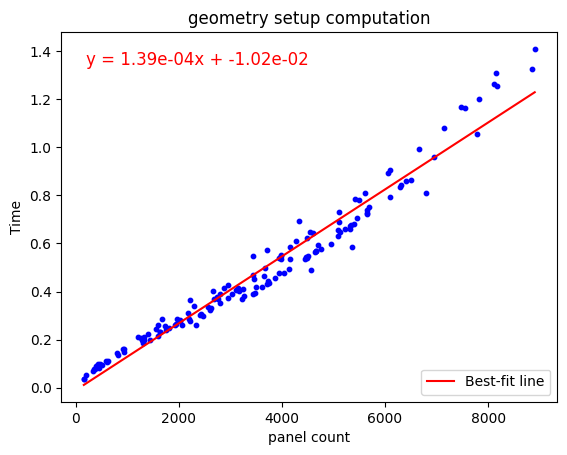

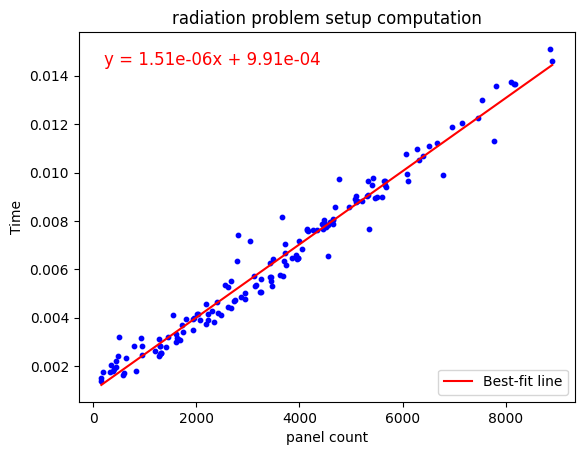

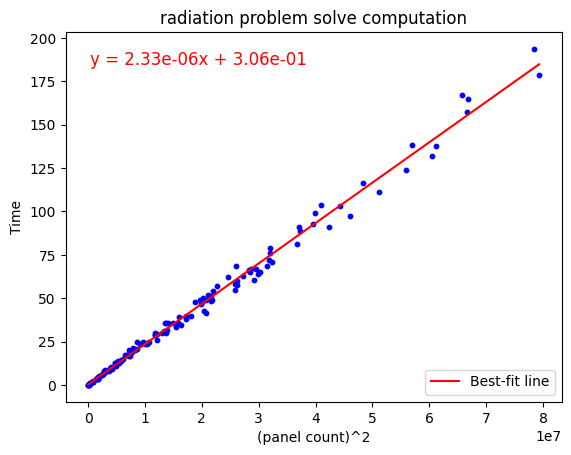

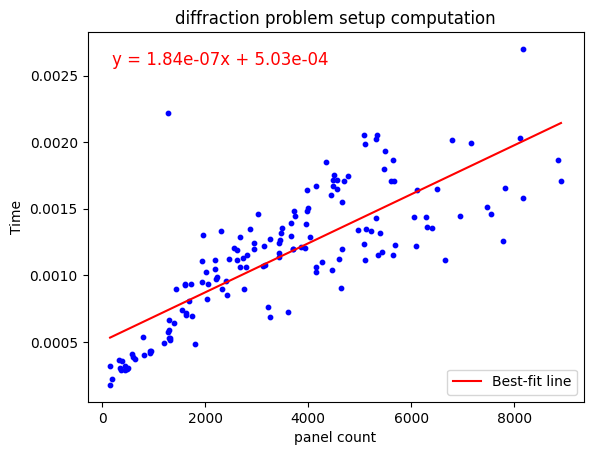

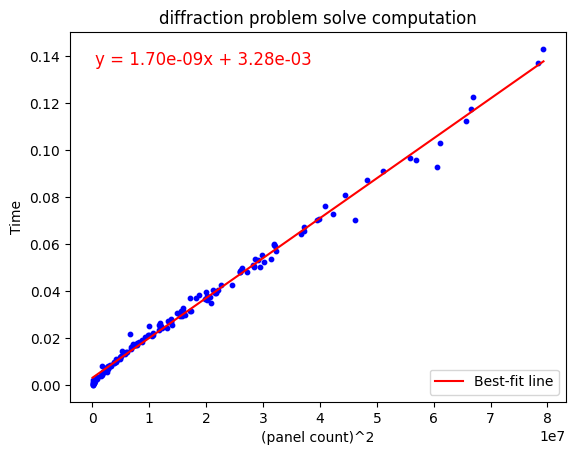

In [7]:
fit_data = {labels[0] : [lambda x, y : x, "panel count"],
            labels[1] : [lambda x, y : x, "panel count"],
            labels[2] : [lambda x, y : x**2, "(panel count)^2"],
            labels[3] : [lambda x, y : x, "panel count"],
            labels[4] : [lambda x, y : x**2, "(panel count)^2"]}

for label in labels:
  plot_dependence(combined_data, label, fit_data[label][0], fit_data[label][1])

In [8]:
# Extrapolate computation time:
def cpt_computation_time(panel_count):
  t1 = 1.2e-4 * panel_count
  t2 = 1.5e-6 * panel_count
  t3 = 2.4e-6 * panel_count**2
  t4 = 3.5e-7 * panel_count
  t5 = 2.5e-9 * panel_count**2
  return sum([t1, t2, t3, t4, t5])